In [1]:
# 🛒 FMCG Sales Forecasting - Modeling

# --- 1. Import libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# Classical time series
import statsmodels.api as sm

# Prophet
from prophet import Prophet

# XGBoost
from xgboost import XGBRegressor

# --- 2. Load and preprocess raw dataset ---
data_path = "/kaggle/input/fmcg-daily-sales-data-to-2022-2024/"
df = pd.read_csv(os.path.join(data_path, "FMCG_2022_2024.csv"))

df['date'] = pd.to_datetime(df['date'])
df['revenue'] = df['units_sold'] * df['price_unit']

# Aggregate to daily
daily = (
    df.groupby('date')['revenue']
    .sum()
    .reset_index()
    .rename(columns={'revenue': 'daily_revenue'})
)

print("✅ Data prepared:", daily.shape)
print(daily.head())

# --- 3. Train/test split (last 90 days for testing) ---
train = daily.iloc[:-90]
test = daily.iloc[-90:]

print("Train:", train.shape, " Test:", test.shape)

# --- 4. Evaluation function ---
def evaluate(y_true, y_pred):
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {"RMSE": rmse, "MAE": mae, "MAPE": mape}

results = {}


✅ Data prepared: (1076, 2)
        date  daily_revenue
0 2022-01-21         440.34
1 2022-01-22         814.23
2 2022-01-23        1067.74
3 2022-01-24         837.30
4 2022-01-25         827.86
Train: (986, 2)  Test: (90, 2)


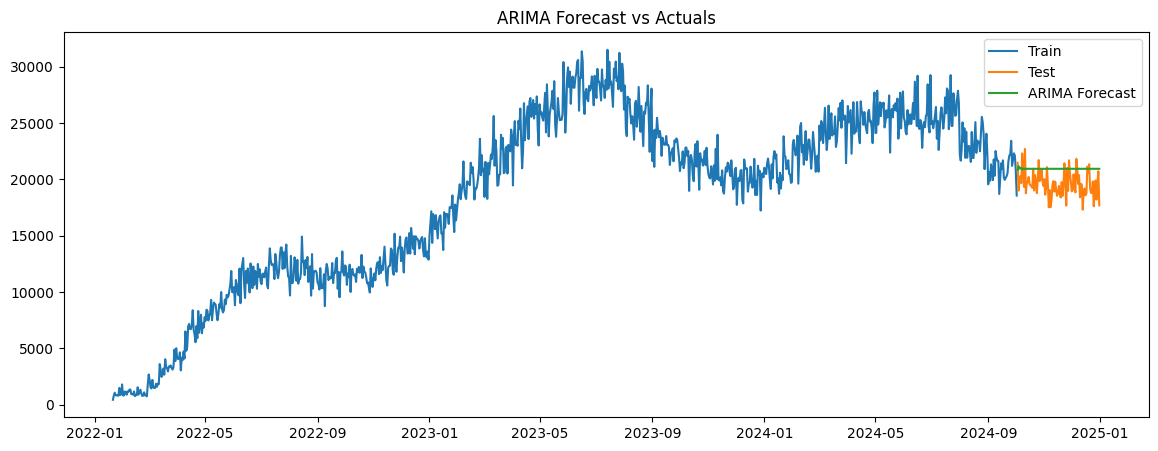

In [2]:
# --- 5. ARIMA model ---
arima_model = sm.tsa.ARIMA(train['daily_revenue'], order=(5,1,2))
arima_fit = arima_model.fit()

forecast_arima = arima_fit.forecast(steps=len(test))
results['ARIMA'] = evaluate(test['daily_revenue'], forecast_arima)

plt.figure(figsize=(14,5))
plt.plot(train['date'], train['daily_revenue'], label="Train")
plt.plot(test['date'], test['daily_revenue'], label="Test")
plt.plot(test['date'], forecast_arima, label="ARIMA Forecast")
plt.legend()
plt.title("ARIMA Forecast vs Actuals")
plt.show()


02:06:24 - cmdstanpy - INFO - Chain [1] start processing
02:06:24 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_13/1525682278.py:49: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


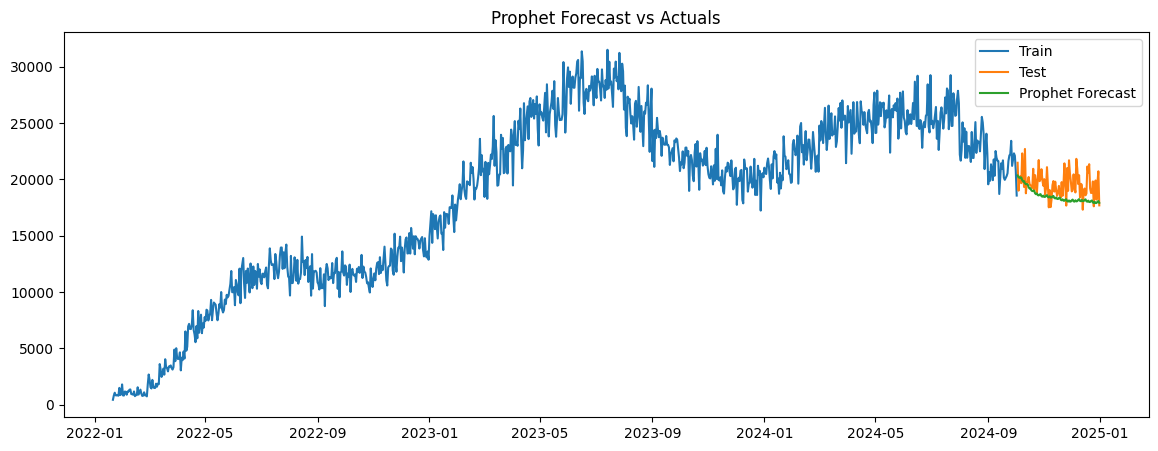

In [3]:
# --- 6. Prophet model ---
prophet_df = train.rename(columns={'date':'ds','daily_revenue':'y'})

prophet = Prophet(yearly_seasonality=True, daily_seasonality=False)
prophet.fit(prophet_df)

future = prophet.make_future_dataframe(periods=len(test))
forecast = prophet.predict(future)

forecast_prophet = forecast[['ds','yhat']].set_index('ds').loc[test['date']]
results['Prophet'] = evaluate(test['daily_revenue'], forecast_prophet['yhat'])

plt.figure(figsize=(14,5))
plt.plot(train['date'], train['daily_revenue'], label="Train")
plt.plot(test['date'], test['daily_revenue'], label="Test")
plt.plot(forecast_prophet.index, forecast_prophet['yhat'], label="Prophet Forecast")
plt.legend()
plt.title("Prophet Forecast vs Actuals")
plt.show()


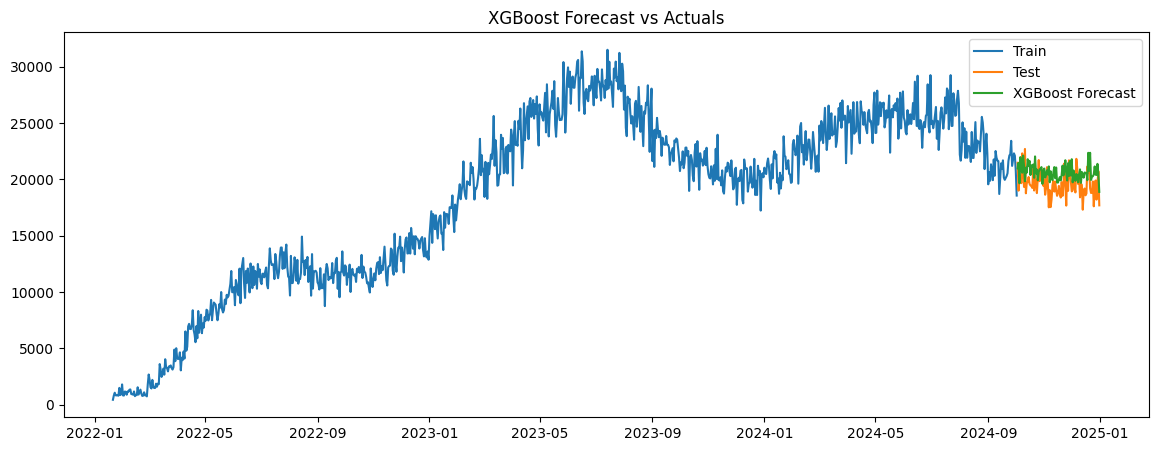

In [4]:
# --- 7. XGBoost Regressor with lag features ---
lag_df = daily.copy()
for lag in [1,7,30]:
    lag_df[f"lag_{lag}"] = lag_df['daily_revenue'].shift(lag)

lag_df = lag_df.dropna()

train_lag = lag_df.iloc[:-90]
test_lag = lag_df.iloc[-90:]

X_train, y_train = train_lag.drop(['date','daily_revenue'], axis=1), train_lag['daily_revenue']
X_test, y_test = test_lag.drop(['date','daily_revenue'], axis=1), test_lag['daily_revenue']

xgb = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5)
xgb.fit(X_train, y_train)

forecast_xgb = xgb.predict(X_test)
results['XGBoost'] = evaluate(y_test, forecast_xgb)

plt.figure(figsize=(14,5))
plt.plot(train['date'], train['daily_revenue'], label="Train")
plt.plot(test['date'], test['daily_revenue'], label="Test")
plt.plot(test_lag['date'], forecast_xgb, label="XGBoost Forecast")
plt.legend()
plt.title("XGBoost Forecast vs Actuals")
plt.show()


                RMSE          MAE      MAPE
ARIMA    1717.796802  1492.669514  7.843468
Prophet  1550.488758  1234.106031       NaN
XGBoost  1584.899545  1350.616893  7.024267


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


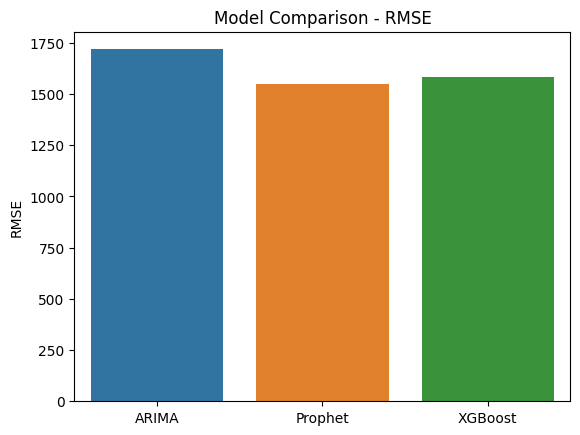

In [5]:
# --- 8. Compare all models ---
results_df = pd.DataFrame(results).T
print(results_df)

sns.barplot(x=results_df.index, y=results_df['RMSE'])
plt.title("Model Comparison - RMSE")
plt.show()
